# Big Red Data Challenge (Spring 2025)

In [154]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import plotly.express as px

# supress warning
import warnings
warnings.filterwarnings('ignore')

# Import data
donor_df = pd.read_excel("./data/all_transactions.xlsx")
# hospital_df = pd.read_excel("./data/survey_responses.xlsx")

In [155]:
len(donor_df)

9488

## Donor Data

Potential Data Goals:
- Improved Fundraising Strategies: Donor data helps identifying trends, preferred donation methods, and the best time to solicit gifts
- Enhanced Donor Retention and Engagement: Help us understand donor behaviors, such as frequency and amount of giving
- Better Decision-Making: Help us prioritize high-value donors, target new donor prospects

### 1. Clean & Explore Data

In [156]:
donor_df.head()

,Account Number,Date,Revenue Amount,Type,Fund,Campaign,Appeal,Primary City,Primary State,Primary ZIP Code
0,8231,2025-02-18,20.76,Recurring Donation Payment,Unrestricted,NaN,NaN,Columbus,OH,43214-4014
1,2139,2025-02-17,78.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Galena,OH,43021
2,1566,2025-02-15,52.30,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Darien,CT,06820-3204
3,10382,2025-02-15,21.11,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,NaN,Columbus,OH,43214
4,9739,2025-02-15,24.23,Recurring Donation Payment,Unrestricted,Sam's Fans 2024,BTJ Website,Dublin,OH,43017


In [157]:
# Remove wrong data points
donor_df = donor_df.loc[donor_df['Date'] > '2014-12-31']
donor_df['Primary City'] = donor_df['Primary City'].str.title()
# donor_df.loc[donor_df['Primary City'].str.contains('james', case=False, na=False)]

In [158]:
# Duplicate records
print('Duplicate entries: {}'.format(donor_df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((donor_df.duplicated().sum()/donor_df.shape[0])*100),2))

Duplicate entries: 287
3% rows are duplicate.


In [159]:
print("Total number of transactions with zero or negative Revenue Amount:", donor_df[donor_df['Revenue Amount'] <= 0 ]['Revenue Amount'].count())
print("Percentage of transactions with zero or negative Revenue Amount" ,round(len(donor_df[donor_df['Revenue Amount']<=0])/len(donor_df)*100, 2),"%")

Total number of transactions with zero or negative Revenue Amount: 335
Percentage of transactions with zero or negative Revenue Amount 3.53 %


In [160]:
# Remove duplicate data
donor_df.drop_duplicates(inplace = True)

# Remove zero or negative revenue amounts
donor_df = donor_df.loc[donor_df["Revenue Amount"] > 0]

# Remove Pledge & Soft Credit
donor_df = donor_df.loc[(donor_df["Type"] != "Pledge") & (donor_df["Type"] != "Pledge Payment") & (donor_df["Type"] != "Soft Credit")]

### 2. Calculate RFM Table
Three key factors:
- **Recency**: how recently a customer has transacted with a brand
- **Frequency**: how frequently they’ve engaged with a brand
- **Monetary**: how much money they’ve spent on a brand’s products and services

In [161]:
donor_df["Date"] = donor_df["Date"].dt.date
last_date = max(donor_df["Date"]) + dt.timedelta(days=1)
donor_df["id"] = donor_df["Account Number"].astype(str)

In [162]:
donor_frequency = donor_df.groupby("id").agg({"Revenue Amount":"sum", 
                                                "Date":lambda x: (last_date - x.max()).days,
                                                "Account Number":"count"}).reset_index()
donor_frequency = donor_frequency.rename(columns={"Revenue Amount":"Monetary",
                                                  "Date":"Recency",
                                                  "Account Number":"Frequency"})
donor_frequency['Recency'] = donor_frequency['Recency'].astype(int)
donor_frequency

,id,Monetary,Recency,Frequency
0,10000,203.0,124,2
1,10001,1650.0,482,3
2,10015,300.0,1217,1
3,10019,500.0,846,1
4,10036,500.0,846,1
...,...,...,...,...
2518,9985,500.0,846,1
2519,9986,4430.9,93,6
2520,9987,740.0,117,5
2521,9988,500.0,118,1


#### Manage Skewness and Scaling

In [163]:
donor_frequency[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,2523.000000,2523.000000,2523.000000
mean,1275.779231,3.480380,1015.343266
std,899.002845,9.767556,4202.858890
min,1.000000,1.000000,1.330000
25%,482.000000,1.000000,43.500000
50%,1217.000000,1.000000,103.300000
75%,2017.000000,2.000000,499.590000
max,3702.000000,123.000000,115000.000000


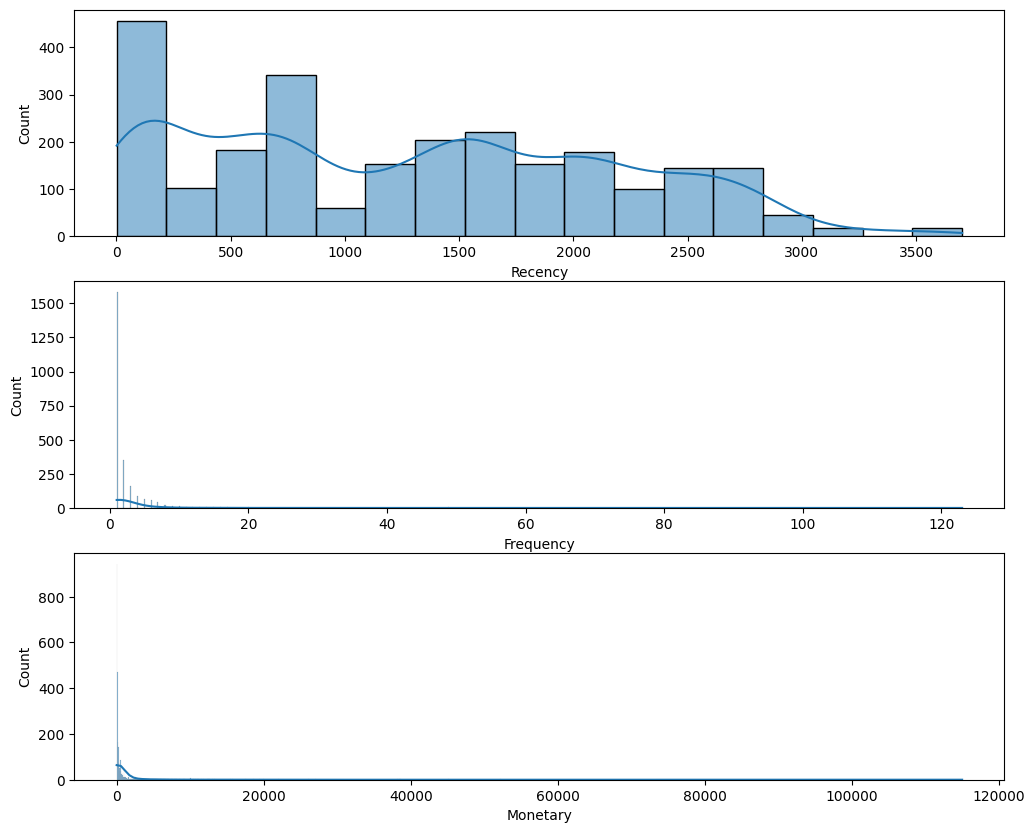

In [164]:
plt.figure(figsize=(12,10))
# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(donor_frequency['Recency'], kde=True)
plt.subplot(3, 1, 2); sns.histplot(donor_frequency['Frequency'], kde=True)
plt.subplot(3, 1, 3); sns.histplot(donor_frequency['Monetary'], kde=True)
plt.show()

Bruh! So weird :)

In [165]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(donor_frequency[x], ax=ax[0,0], kde=True)
    sns.histplot(np.log(donor_frequency[x]), ax=ax[0,1], kde=True)
    sns.histplot(np.sqrt(donor_frequency[x]), ax=ax[1,0], kde=True)
    sns.histplot(stats.boxcox(donor_frequency[x])[0], ax=ax[1,1], kde=True)
    plt.tight_layout()
    plt.show()
    
    print('Log Transform : The skew coefficient of', donor_frequency[x].skew().round(2), 'to', np.log(donor_frequency[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', donor_frequency[x].skew().round(2), 'to', np.sqrt(donor_frequency[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', donor_frequency[x].skew().round(2), 'to', pd.Series(stats.boxcox(donor_frequency[x])[0]).skew().round(2))

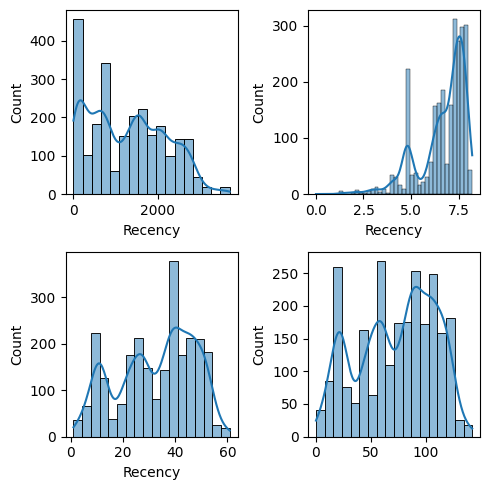

Log Transform : The skew coefficient of 0.28 to -1.38
Square Root Transform : The skew coefficient of 0.28 to -0.32
Box-Cox Transform : The skew coefficient of 0.28 to -0.28


In [166]:
analyze_skewness('Recency')

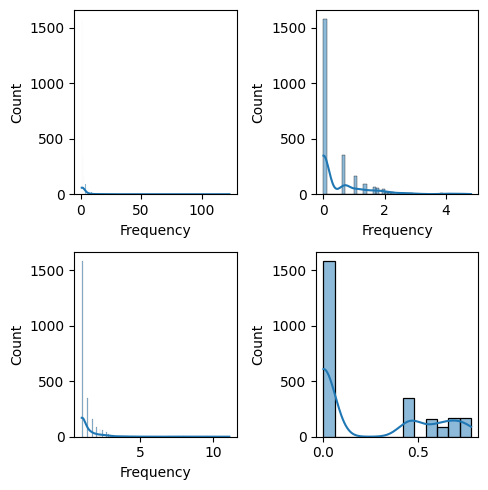

Log Transform : The skew coefficient of 7.41 to 2.05
Square Root Transform : The skew coefficient of 7.41 to 4.57
Box-Cox Transform : The skew coefficient of 7.41 to 0.7


In [167]:
analyze_skewness('Frequency')

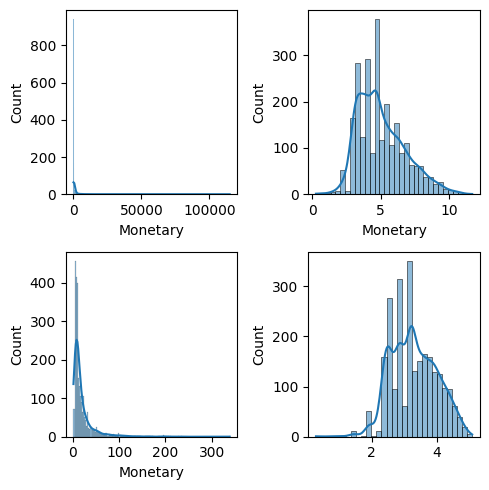

Log Transform : The skew coefficient of 12.88 to 0.73
Square Root Transform : The skew coefficient of 12.88 to 4.15
Box-Cox Transform : The skew coefficient of 12.88 to 0.04


In [168]:
analyze_skewness('Monetary')

Not really optimal but Box-Cox Transformation Then?

In [169]:
# Transform data
transformed_fr = donor_frequency.copy()
transformed_fr["Recency"] = stats.boxcox(transformed_fr['Recency'])[0]
transformed_fr["Frequency"] = stats.boxcox(transformed_fr['Frequency'])[0]
transformed_fr["Monetary"] = stats.boxcox(transformed_fr['Monetary'])[0]

In [170]:
# scale the data
dt = transformed_fr[["Recency", "Frequency", "Monetary"]]

scaler = StandardScaler()
scaler.fit(dt)
donor_normalized = scaler.transform(dt)

### 3. Make Segmentations: K-Means Clustering

In [171]:
k_ranges = range(1, 10)

distortions = []
inertias = []
mapping1 = {}
sse = {}

for k in k_ranges:
    kmeans = KMeans(n_clusters=k, random_state=23)
    kmeans.fit(donor_normalized)

    distortions.append(sum(np.min(cdist(donor_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / donor_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(donor_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / donor_normalized.shape[0]
    
    sse[k] = kmeans.inertia_

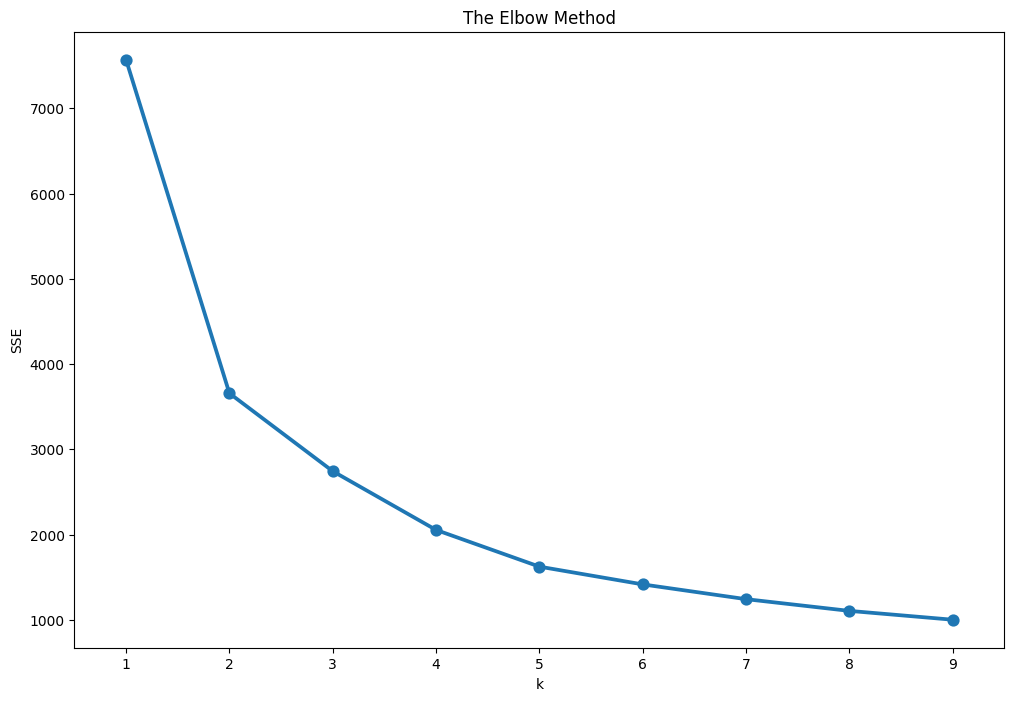

In [172]:
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Optimal point maybe k = 3

In [194]:
model = KMeans(n_clusters=3, random_state=23)
model.fit(donor_normalized)     

KMeans(n_clusters=3, random_state=23)

In [195]:
donor_frequency["Cluster"] = model.labels_
donor_frequency

,id,Monetary,Recency,Frequency,Cluster
0,10000,203.0,124,2,0
1,10001,1650.0,482,3,0
2,10015,300.0,1217,1,1
3,10019,500.0,846,1,1
4,10036,500.0,846,1,1
...,...,...,...,...,...
2518,9985,500.0,846,1,1
2519,9986,4430.9,93,6,0
2520,9987,740.0,117,5,0
2521,9988,500.0,118,1,1


#### Cluster Visualization

In [196]:
# Generate dataframe for cluster visualization
normalized_df = pd.DataFrame(donor_normalized, columns=['Recency', 'Frequency', 'Monetary'])
normalized_df['Cluster'] = model.labels_
normalized_df['id'] = donor_frequency.index

normalized_df_melt = pd.melt(normalized_df.reset_index(),
                            id_vars=["id", "Cluster"],
                            value_vars=['Recency','Frequency','Monetary'],
                            var_name='Attribute',
                            value_name='Value')

cluster_viz = normalized_df_melt.groupby('Cluster').agg({'id': lambda x: len(x)}).reset_index()

cluster_viz.rename(columns={'id': 'Count'}, inplace=True)
cluster_viz['Percentage'] = (cluster_viz['Count'] / cluster_viz['Count'].sum()) * 100
cluster_viz['Percentage'] = cluster_viz['Percentage'].round(2)
cluster_viz

,Cluster,Count,Percentage
0,0,2421,31.99
1,1,1842,24.34
2,2,3306,43.68


In [197]:
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4']
fig = px.treemap(cluster_viz, path=['Cluster'],values='Count', 
                 width=800, height=400,
                 title="Distribution of Cluster")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

<Axes: xlabel='Attribute', ylabel='Value'>

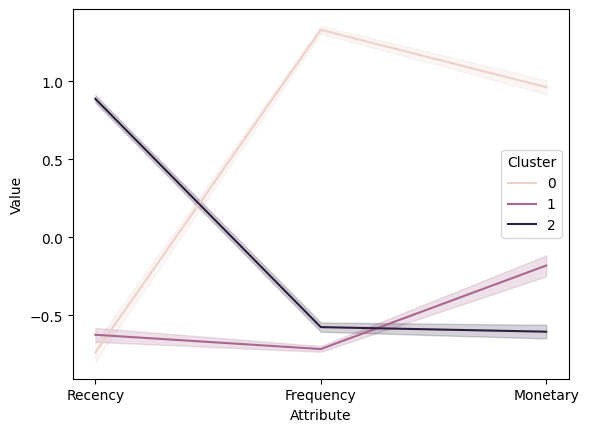

In [198]:
# Visualize it
sns.lineplot(data = normalized_df_melt, x = 'Attribute', y = 'Value', hue='Cluster')

| Cluster | % | Summary | Suggested Labels |
| --- | --- | --- | --- |
| 0 | 31.99 | Donors who donate often, donate a lot, and donate recently | Loyal donors |
| 1 | 24.34 | These are occasional or one-time donors, maybe worth re-engaging  | New donors |
| 2 | 43.68 | Donors who used to donate a long time ago and donate just a little | Lost donors |

#### Importance of segments

In [212]:
quantiles = donor_frequency.quantile(q=[0.25,0.5,0.75], numeric_only=True)

def calScore(x, p, d):
    if x <= d[p][0.25]:
        return 4 if p == 'Recency' else 1
    elif x <= d[p][0.50]:
        return 3 if p == 'Recency' else 2
    elif x <= d[p][0.75]: 
        return 2 if p == 'Recency' else 3
    else:
        return 1 if p == 'Recency' else 4
    


,Monetary,Recency,Frequency,Cluster
0.25,43.50,482.0,1.0,0.0
0.50,103.30,1217.0,1.0,1.0
0.75,499.59,2017.0,2.0,2.0


## Hospital Data

Potential Data Goals:
- Resource Allocation: Help us allocate resource effectively